<a href="https://colab.research.google.com/github/TravelingEngineer/Sandbox/blob/master/Training_Rev3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Unpack Ngrok**

# Tensorboard Config

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-02-26 03:20:29--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.206.36.121, 34.232.40.183, 34.231.75.48, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.206.36.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  3.45MB/s    in 1.5s    

2019-02-26 03:20:32 (3.45 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


**Start Tensorboard**

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

**Start Ngrok**

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

**Retrieve URL for Tensorboard**

In [0]:
#click on link generated to open Tensorboard
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://4e1626d3.ngrok.io


In [0]:
#tensorflow specific libraries
import tensorflow as tf
from tensorflow.python.data import Dataset
import keras
from keras.layers import Input, Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.callbacks import TensorBoard

#tf.enable_eager_execution() #tf.placeholder not compatible with eager execution, used for autoencoder

tf.logging.set_verbosity(tf.logging.ERROR) #sets threshold for what is logged in tenserflow

# Colaboratory Config

**Install dependencies**

In [0]:
!pip install git+https://github.com/jameslyons/python_speech_features.git
#!pip install git+https://github.com/bmcfee/resampy.git
#!pip install git+https://github.com/numba/numba.git    #used for resampy
#!pip install git+https://github.com/librosa/librosa.git

  Cloning https://github.com/jameslyons/python_speech_features.git to /tmp/pip-req-build-7JcqxJ
  Stored in directory: /tmp/pip-ephem-wheel-cache-A0pNa5/wheels/37/1f/0e/01b5393897b85f27e49a2c823d6efbbe71f480a34cdb3a84c2
Successfully built python-speech-features


In [0]:
#from gammatone import gtgram
from python_speech_features import mfcc
from python_speech_features import logfbank
from python_speech_features import fbank
from python_speech_features import delta

**Import Libraries and Methods**

In [0]:
from __future__ import division #import python 3 updates for floating point division
from __future__ import print_function

import os
import math
import librosa

from IPython.display import Audio
from scipy.io import wavfile
from scipy import signal
from matplotlib import cm
from matplotlib import gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

import datetime
import numpy as np
from numpy import mean, sqrt, square, arange
import random
import numpy.random 
import pandas as pd
from sklearn import metrics

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

**Google Drive Configuration **

In [0]:
from google.colab import auth
from google.colab import files
#email Collins.AE6@gmail.com
#pswd machine_learning610
from google.colab import drive
drive.mount('/content/drive')

#Upload data from GoogleDrive
gDrive= '/content/drive/My Drive/Training_Database/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Audio File Processing

In [0]:
#check for data
!ls "/content/drive/My Drive/Training_Database"

 Anechoic_Audio_16_16k_Mono.wav       'old audio roughwork'
 Anechoic_Audio_16_44k_Mono.wav        speech_convolved_normalized.wav
 data%2Fspeech_commands_v0.02.tar.gz   test_16_bit.wav
 gaussian_database3		       ZOOM0005_LR_16_sampled_down_b.wav


**Write Audio to Array**

In [0]:
#Audio files must be .wave 16-bit 44 kHz format
file_speech = gDrive+'ZOOM0005_LR_16_sampled_down_b.wav'
fs, sig_speech = wavfile.read(file_speech)
#fs_original, sig_speech = wavfile.read(file_speech)

#audio formatting
sig_speech = sig_speech.astype(np.float32) #converts wavfile from read only to write access default float is 64, specify 32 for tensorflow
sig_speech /= 2**15 #normalizes 16 bit wavefile

In [0]:
sig_speech.shape

(7023840,)

**If resampling required on wav file, use Resample_Audio code**

**Extract random 2s clip from audio array**

In [0]:
#segment_length=3 #duration in [s] of random segment from audio file
#random_start=np.random.uniform(low=0,high=len(sig_speech)/fs-segment_length) #want to pull 30 random starts from audio file but get error size=(1,30)
#random_start_int=random_start.astype(np.int)
# random_start_int=random_start_int[:,np.newaxis]
#test=random_start_int*fs
#sig_speech_sample=sig_speech[random_start_int*fs:(random_start_int*fs+segment_length*fs)] #TypeError: only integer scalar arrays can be converted to a scalar index
#random_start_int.shape
#sig_speech_sample(1)

#Grab a 6 sec chunk from the available data
Segment_length=2*fs
Random_Start=int(np.random.uniform(0,len(sig_speech)-Segment_length))
sig_speech_sample=sig_speech[Random_Start:(Random_Start+Segment_length)]

In [0]:
sig_speech_sample.shape

(32000,)

In [0]:
#play Audio for check
Audio(sig_speech_sample, rate=fs)
#len(sig_speech_sample)

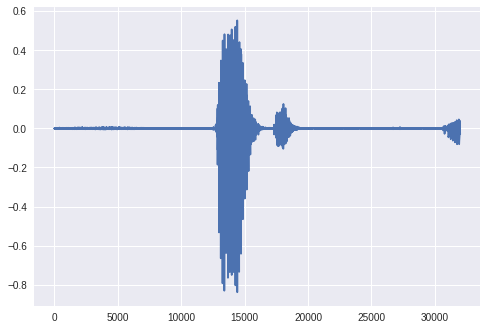

In [0]:
#display Audio for check
plt.plot(sig_speech_sample)
plt.show()

In [0]:
#sig_speech_to_convolve = sig_speech[np.newaxis] #shape array for convolution with gaussian impulse

# MFSC and Spectrogram Feature Extraction

**MFSC configuration**

In [0]:
sig_speech_sample.shape

(32000,)

In [0]:
mfsc=logfbank(sig_speech_sample,
         fs,
         winlen=0.04, #40 ms window
         winstep=0.04/8, #12.5% overlap
         nfilt=40, #number of triangular filter banks
         nfft=2048, #N-point FFT on each frame 246 or 512 used 
         lowfreq=20,
         highfreq=8000,
         preemph=0) #historical balences frequency spectrum since high frequencies have 
                       #smaller magnitudes, than low frequencies 

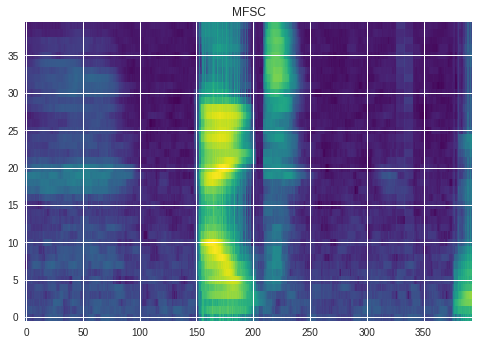

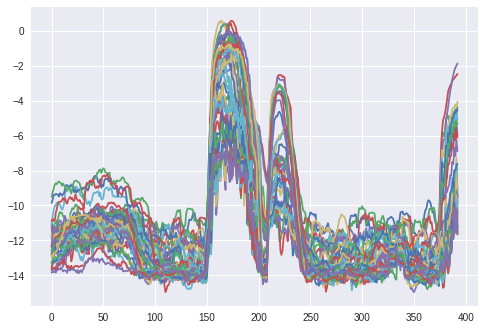

In [0]:

ig, ax = plt.subplots()
mfsc_feature= np.swapaxes(mfsc, 0 ,1)
cax = ax.imshow(mfsc_feature, interpolation='nearest', cmap=cm.viridis, origin='lower', aspect='auto')
ax.set_title('MFSC')
#Showing mfsc_data
plt.show()
plt.plot(mfsc)
plt.show()

**Signal to Noise Ratio Check**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


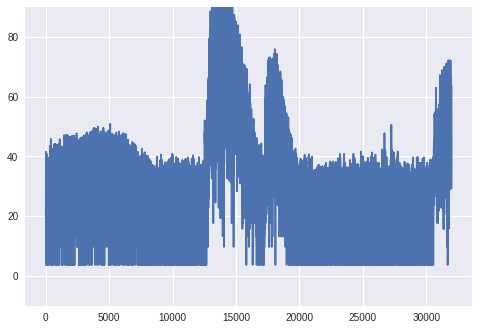

742

In [0]:
dB_calibration = (20e-6)#*(math.sqrt(2)) #manually adjusted 20*10^-6
dB_sig_speech_sample = 20*np.log10(abs(sig_speech_sample)/dB_calibration) #convert wav recording to dB
dB_sig_speech_sample
#sig_speech_sample
plt.ylim(-10,90)
plt.plot(dB_sig_speech_sample)
plt.show()
np.isneginf(dB_sig_speech_sample).sum() #number of zero crossings
                                        #bottom of what is plotted is point just before zero

**Spectrogram Config**

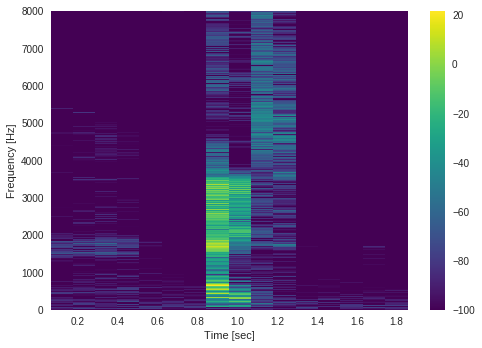

In [0]:
f, t, Sxx = signal.spectrogram(
    sig_speech_sample, 
    fs, 
    window=('hann'), #FFT window
    nperseg=2048, #length of window, default is 256, with 44[kHz] sample rate gives 5[ms] window, 2048 is 40 [ms]
    noverlap=None, #default window overlap is nperseg/8 which is ~12.5% overlap
    nfft=None,     #no padding
    detrend='constant', #if low frequency drift offset change
    return_onesided=True, #for hilbert when you have a complex raw signal
    scaling='density', #use density from broadband noise, tonal noise use spectrum
    axis=-1, #align with time access, raw mono audio is 1-D
    mode='psd')

#norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
dB_spectrum = 20*np.log10(Sxx/dB_calibration)
cmap = plt.get_cmap('viridis') #winter, summer, grey, hot
plt.pcolormesh(t, f, dB_spectrum, cmap=cmap, vmin=-100) # norm=LogNorm(vmin=Sxx.min(),vmax=Sxx.max() Sxx.min() 10**-8
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.ylim(50,20000)
plt.show()

# Impulse Response Generation

**Generate Exponential Decay Curve With White Noise**

In [0]:
framerate = 16000 #match sample frequency of wav file [Hz]
length = 2 #duration in [s]
t = np.linspace(0,length,length*framerate)
t = t[np.newaxis]

#rt=np.linspace(0.5, 3, num=30) #creates 1-D array #logspace np.log10(0.2) np.log10(2.5) of number of rt?
#rt=np.random.randint(0.25,2.5,30)

#30 X 1 randomized RT array from 0.5s to 3
rt_random = np.round(numpy.random.uniform(0.5, 3, size=(30,)),1)
rt_random.size


30

In [0]:
tau=rt_random/6.9   #relationship between average decay damping and RT60
tau = tau[:,np.newaxis] #slices Tau for broadcasting
data=np.exp(-t/tau)
#data.shape
#data.size
noise = np.random.normal(0, 1, t.size) #random samples from a gaussian distribution, use full size of t
noise /= np.max(noise) #normalizes gaussian noise 
gaussian_impulse= data*noise
#tau
gaussian_impulse.shape
#randomized_gaussian_impulse=random.shuffle(gaussian_impulse)
#randomized_gaussian_impulse.shape

(30, 32000)

In [0]:
Audio(gaussian_impulse[1], rate=fs)

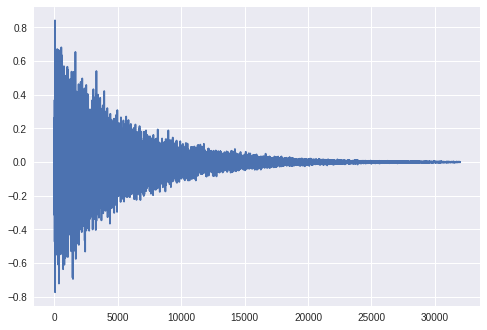

In [0]:
plt.plot(gaussian_impulse[0])
#plt.ylabel('some numbers')
plt.show()

# Convolve Audio Sample with Impulse Response

**Convolution  of Audio File Segments with Generated Decay Curves**

In [0]:
sig_speech_sample = sig_speech_sample[np.newaxis] #shape array for convolution with gaussian impulse
speech_convolved = signal.fftconvolve(sig_speech_sample,gaussian_impulse)
speech_convolved.shape

(30, 63999)

In [0]:
fft_even_end = length*fs 
speech_convolved_even = speech_convolved[:,0:fft_even_end]
speech_convolved_even.shape

(30, 32000)

In [0]:
speech_convolved_even

array([[-4.75111420e-05, -1.56051732e-04, -2.33658207e-04, ...,
        -3.28553187e-01, -3.39609776e-01, -4.01677846e-01],
       [-4.75111420e-05, -1.56049421e-04, -2.33658765e-04, ...,
        -3.98259692e-01, -4.01853307e-01, -4.05312037e-01],
       [-4.75111420e-05, -1.56047180e-04, -2.33659306e-04, ...,
        -3.86082970e-01, -3.89980901e-01, -3.83000242e-01],
       ...,
       [-4.75111420e-05, -1.56045313e-04, -2.33659756e-04, ...,
        -3.68035586e-01, -3.72063629e-01, -3.63032517e-01],
       [-4.75111420e-05, -1.56042379e-04, -2.33660463e-04, ...,
        -3.39695238e-01, -3.43542336e-01, -3.33700533e-01],
       [-4.75111420e-05, -1.56051181e-04, -2.33658340e-04, ...,
        -3.64391880e-01, -3.71264053e-01, -4.09129700e-01]])

In [0]:
Audio(speech_convolved_even[0], rate=fs)

In [0]:
#os.mkdir(gDrive+'gaussian_database3')
#for rt, speech_con in zip(rt,speech_convolved): #pair Rt to speech_convolved
#  speech_con_normalized = speech_con/np.max(np.abs(speech_con))  
#  speech_con_normalized *= 2**15
#  speech_con_normalized = speech_con_normalized.astype(np.int16)

#  outfile = gDrive+'gaussian_database/speech_con_norm_{rt:g}_s.wav' #format name to include RT value
#  wavfile.write(outfile, fs, speech_con_normalized)
#files.download(outfile)

# Take Signal Envelope

**Apply Hilbert Transform**

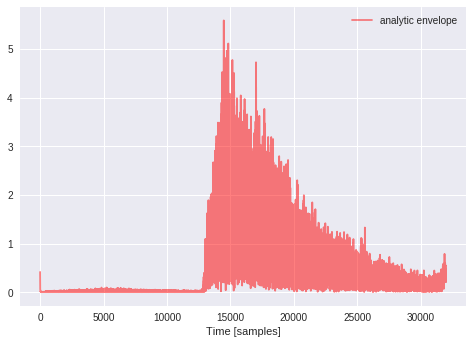

In [0]:
#original audio file
#fig = plt.figure()
#axes1 = fig.add_subplot(111) #set props for left y-axis here

#axes1.set_ylabel('original convolved file')
#axes2 = axes1.twinx() #mirror axis
#axes2.set_ylabel('phase angle')

#plot original file
#plt.plot(speech_convolved, label = 'original file', color = 'black', alpha = 1)

analytical_impulse = signal.hilbert(speech_convolved_even, axis=1)
#plt.plot(analytical_impulse.real, label = 'analytic real part', color = 'red', alpha = 0.5)
#plt.plot(analytical_impulse.imag, label = 'analytic imaginary part', color = 'blue', alpha = 0.5)

envelope_analytical_impulse = np.abs(analytical_impulse)
plt.plot(envelope_analytical_impulse[0], label = 'analytic envelope', color = 'red', alpha = 0.5)

#phase_radians =np.angle(analytical_impulse)
#phase_angle = np.cos(phase_radians)
#plt.plot(phase_angle, label = 'phase angle', color = 'blue', alpha = 0.5)

#display settings
#plt.ylabel('Impulse Response')
plt.xlabel('Time [samples]')
plt.legend()

#calculates segement of file to display
#time = 2 #in seconds
#points_to_plot = fs*time
#plt.xlim(0.014*fs,0.025*fs) #(0.014*fs,0.025*fs)
#plt.ylim(-0.1,0.1)

plt.show()

# Dimensionality Reduction

**Output Files**

**Autoencoder Config**

In [0]:
264599/1024

258.3974609375

In [0]:
# size of encoded representations
encoding_dim = 1024 #1024 floats -> compression factor 258.4, w/ input 264599 float convolved audio file

# input placeholder
input_initalization = Input(shape=(264599,))
# "encoded" is representation of input
encoded = Dense(encoding_dim, activation='relu')(input_initalization)

#dense layer with regularizer (sparsity constraint)
#encoded = Dense(encoding_dim, activation='relu',
               #activity_regularizer=regularizers.l1(10e-5))(input_img)
# "decoded" is lossy reconstruction of input
decoded = Dense(264599, activation='sigmoid')(encoded)

#this model maps an input to reconstruction represenation
autoencoder = Model(input_initalization,decoded)
#this model maps an input to encoded represenation
encoder = Model(input_initalization,encoded)
#create a placeholder for encoded (1024-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
#create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

NameError: ignored

**Optimizer Configuration**

In [0]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') #optimizer options adam, adadelta

**Partition dataset into training and test sets**

In [0]:
# first 15 files (out of 20) for training
training_examples = speech_convolved[0:9,:] #grabs first part of data
training_targets = speech_convolved[10:15,:] #grabs end part of data

Autoencoder training

In [0]:
#training for 5 epochs
autoencoder.fit(training_examples, training_examples,
               epochs=5,
               batch_size=256,
               shuffle=True,
               validation_data=(training_targets, training_targets))

# Convolution Neural Network

**Partition dataset into training and validation set**

In [0]:
# first 15 files (out of 20) for training
data_size = rt_random.size

data_mid = data_size/2
data_mid = int(data_mid)

training_data = speech_convolved_even[0:data_mid,:] #grabs first part of dataset
validation_data = speech_convolved_even[data_mid:,:] #grabs end part of dataset


#format data for convolutional filter
training_data = np.swapaxes(training_data,0,1)
training_size = training_data.shape
training_data = training_data[:,:,np.newaxis]

validation_data = np.swapaxes(validation_data,0,1)
validation_data = validation_data[:,:,np.newaxis]

(32000, 15)

# Neural Network Configuration

**Declare Model Type**

In [0]:
model = Sequential() #stacked layers of neural network

**Convolution Layer #1**

In [0]:
#adds a 1D convolutional layer, 1 dimension (temporal) on raw audio
#config is 32 output chanels, 
#kernal size is 5x5 moving window, 
#strides in x and y directions (1,1)
#rectilinear activation function, provide size of input to the layer, size only required for first 
#layer after that keras can calculate size of tensors
#in keras don't need to declare weights or biases variables, done for you with program

model.add(Conv1D(256, 
                 kernel_size=1,        #setup window size to be equal to strides for no overlap    
                 strides= 1,            #25ms stride window with 16kHz sampling rate gives a window ever 400 points for a total of 240 windows.     
                 activation='relu',           #rectilinear activation function
                 input_shape=training_size)) #training_data.shape[0]) input_shape = (img_x, img_y, 1)

ValueError: ignored

In [0]:
#############code doesn't work yet####

#adds a 2D convolutional layer, 
#config is 32 output chanels, 
#kernal size is 5x5 moving window, 
#strides in x and y directions (1,1)
#rectilinear activation function, provide size of input to the layer, size only required for first 
#layer after that keras can calculate size of tensors
#in keras don't need to declare weights or biases variables, done for you with program

#model.add(Conv2D(32, 
                 #kernel_size=(1, 1),        #setup window size to be equal to strides for no overlap    
                 #strides=(1, 1),            #25ms stride window with 16kHz sampling rate gives a window ever 400 points for a total of 240 windows.     
                 #activation='relu',           #rectilinear activation function
                 #input_shape=32000, 15, 1) #training_data.shape[0]) input_shape = (img_x, img_y, 1)

**Pooling Layer #1**

In [0]:
model.add(MaxPooling1D(pool_size=(128), strides=(1))) #setup pooling layer, size of pooling in x, y dimensions and strides in x,y

**Convolution Layer #2**

In [0]:
model.add(Conv1D(64, 
                 kernel_size=(1),        #setup window size to be equal to strides for no overlap    
                 strides=(1),            #25ms stride window with 16kHz sampling rate gives a window ever 400 points for a total of 240 windows.     
                 activation='relu'))          #rectilinear activation function
                                              #shape is tracked in Keras after initializing so no need to specify input shape again.

**Pooling Layer #2**

In [0]:
model.add(MaxPooling1D(pool_size=(32), strides=(1))) #setup pooling layer, size of pooling in x, y dimensions and strides in x,y

**Flatten Pooling Layers & Connect To Fully Connected Layer**

In [0]:
model.add(Flatten())
model.add(Dense(1000, activation='relu'))

ValueError: ignored

**Output Layer**

In [0]:
model.add(Dense(1, activation='linear')) #gives one linear output layer for regression, if classification typically Dense(num_classes, activation='softmax'))

# Training Neural Network

**Compile Network**

In [0]:
model.compile(loss=keras.losses.mean_squared_error, #defines loss function and optimizer, standard cross entropy for categorical class classification #categorical_crossentropy
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])                       #specifies a metric that will be calculated during operation

**Hyperparameters**

In [0]:
batch_size = 15
epochs = 10 #of iterations

**Tensorboard Parameter Config**

In [0]:
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size)

**Format Datasets For Convolution**

In [0]:
training_data = training_data[:,:,np.newaxis]
validation_data = validation_data[:,:,np.newaxis]

In [0]:
validation_data.shape

(32000, 15, 1)

**Training Parameters**

In [0]:
model.fit(training_data, #pass in all training data, next define batch, training epochs, verbose defines what info is printed, x_train, y_train
          batch_size=batch_size, #pass validation or test data to the fit function so Keras knows what data to test metric against when evaluate is run on model
          epochs=epochs, 
          verbose=1,
          validation_data=(rt_random), #evaluates loss function on this dataset per epoch 
          callbacks=[tbCallBack])
score = model.evaluate(validation_data, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, 11), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

ValueError: ignored